In [1]:
import os
import json
import pandas as pd
from tabulate import tabulate

In [2]:
def visualize_results(
    results_path="tnqeet/dotting_models/llms/evaluation_results/val_dataset/",
    sort_by="WER",
    ascending=True,
    print_rows=True,
):

    data = []
    
    # Walk through directory structure
    for root, dirs, files in os.walk(results_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                
                # Parse path to extract metadata
                path_parts = root.split(os.sep)
                evaluation_type = path_parts[-2]  # e.g., "zeroshot" or "fewshot_5"
                prompt_type = path_parts[-1].replace('_prompt', '')  # e.g., "default" or "detailed"
                model_name = file.replace('.json', '')
                
                # Extract fewshot number
                if evaluation_type == "zeroshot":
                    fewshot = 0
                else:
                    fewshot = int(evaluation_type.split('_')[1])
                
                # Load results
                with open(file_path, 'r', encoding='utf-8') as f:
                    results = json.load(f)
                
                # Calculate metrics
                avg_wer = sum(r["wer"] for r in results) / len(results)
                avg_cer = sum(r["cer"] for r in results) / len(results)
                avg_doer = sum(r["doer"] for r in results) / len(results)
                
                # Handle time parsing (stored as string)
                times = []
                for r in results:
                    time_str = str(r["dotting_time"])
                    if time_str == "inf":
                        times.append(float('inf'))
                    else:
                        # Parse "0:00:01.850776" format
                        parts = time_str.split(':')
                        if len(parts) == 3:
                            h, m, s = parts
                            times.append(int(h) * 3600 + int(m) * 60 + float(s))
                        else:
                            times.append(float(time_str))
                avg_time = sum(times) / len(times)
                
                data.append({
                    "LLM": model_name,
                    "Prompt Style": prompt_type,
                    "Fewshot": fewshot,
                    "Inference Time": f"{avg_time:.2f}s",
                    "WER": f"{avg_wer:.4f}",
                    "CER": f"{avg_cer:.4f}",
                    "DOER": f"{avg_doer:.4f}"
                })
    
    # Create DataFrame and sort
    df = pd.DataFrame(data)
    df = df.sort_values(by=sort_by, ascending=ascending)
    
    if print_rows:
        print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))
    
    return df

In [3]:
rows = visualize_results()

+--------------------------+----------------+-----------+------------------+--------+--------+--------+
| LLM                      | Prompt Style   |   Fewshot | Inference Time   |    WER |    CER |   DOER |
+==========================+================+===========+==================+========+========+========+
| claude-sonnet-4          | default        |         8 | 8.09s            | 0.1416 | 0.0375 | 0.044  |
+--------------------------+----------------+-----------+------------------+--------+--------+--------+
| claude-sonnet-4          | detailed       |         8 | 8.35s            | 0.1424 | 0.0379 | 0.0444 |
+--------------------------+----------------+-----------+------------------+--------+--------+--------+
| claude-sonnet-4          | default        |        10 | 15.58s           | 0.1506 | 0.0404 | 0.0474 |
+--------------------------+----------------+-----------+------------------+--------+--------+--------+
| claude-sonnet-4          | detailed       |        10 | 9.31s 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_grouped_bars(rows=rows, metric='WER', figsize=(30, 12), max_y=None):
    """
    Create grouped bar chart for any metric with improved aesthetics.
    
    Args:
        rows: DataFrame from visualize_results function
        metric: Metric to plot ('WER', 'CER', 'DOER', 'Inference Time')
        figsize: Figure size tuple
        max_y: Maximum y-axis value (auto-calculated if None)
    """
    if rows is None:
        raise ValueError("Please provide the rows DataFrame")
    
    # Set up metric column and defaults
    metric_defaults = {
        'WER': {'max_y': 0.75, 'unit': ''},
        'CER': {'max_y': 0.5, 'unit': ''},
        'DOER': {'max_y': 0.8, 'unit': ''},
        'Inference Time': {'max_y': 10, 'unit': ' (seconds)'}
    }
    
    if metric not in metric_defaults:
        raise ValueError(f"Metric must be one of: {list(metric_defaults.keys())}")
    
    # Convert metric to numeric
    if metric == 'Inference Time':
        # Parse time strings to seconds
        rows['metric_numeric'] = rows[metric].str.replace('s', '').astype(float)
    else:
        rows['metric_numeric'] = pd.to_numeric(rows[metric])
    
    # Set default max_y if not provided
    if max_y is None:
        max_y = metric_defaults[metric]['max_y']
    
    # Sort models by average performance (best to worst)
    model_avg = rows.groupby('LLM')['metric_numeric'].mean()
    model_avg = model_avg.sort_values()  # Lower time is better
    models = model_avg.index.tolist()
    
    fewshot_values = sorted(rows['Fewshot'].unique(), reverse=True)
    
    # Set up the plot with improved styling
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create gradient colors for fewshot progression
    n_shots = len(fewshot_values)
    colors_default = plt.cm.Blues(np.linspace(0.9, 0.3, n_shots))
    colors_detailed = plt.cm.Oranges(np.linspace(0.9, 0.3, n_shots))
    
    x = np.arange(len(models))
    width = 0.7 / n_shots
    
    # Plot bars for each fewshot value
    for i, fewshot in enumerate(fewshot_values):
        default_vals = []
        detailed_vals = []
        
        for model in models:
            default_row = rows[(rows['LLM'] == model) & 
                              (rows['Fewshot'] == fewshot) & 
                              (rows['Prompt Style'] == 'default')]
            detailed_row = rows[(rows['LLM'] == model) & 
                               (rows['Fewshot'] == fewshot) & 
                               (rows['Prompt Style'] == 'detailed')]
            
            default_vals.append(default_row['metric_numeric'].iloc[0] if not default_row.empty else 0)
            detailed_vals.append(detailed_row['metric_numeric'].iloc[0] if not detailed_row.empty else 0)
        
        offset = (i - n_shots/2 + 0.5) * width
        
        # Plot bars with gradient colors
        ax.bar(x + offset, default_vals, width/2.2, 
               color=colors_default[i], alpha=0.8, 
               edgecolor='white', linewidth=0.8)
        ax.bar(x + offset + width/2.2, detailed_vals, width/2.2, 
               color=colors_detailed[i], alpha=0.8,
               edgecolor='white', linewidth=0.8)
    
    # Customize aesthetics
    ylabel = f'{metric}{metric_defaults[metric]["unit"]}'
    ax.set_ylabel(ylabel, fontsize=20, fontweight='bold', labelpad=15)
    ax.set_title(f'Model Performance: {metric} by Few-shot Configuration and Prompt Style', 
                 fontsize=20, fontweight='bold', pad=25)
    
    # Set axis properties
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=18, fontweight='bold', rotation=45, ha='right') 
    ax.set_ylim(0, max_y)
    ax.tick_params(axis='y', labelsize=18)
    
    # Improve grid
    ax.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Create custom legend with fewer labels
    legend_elements = []
    
    # Add fewshot labels (gradient indication)
    for i, fewshot in enumerate(fewshot_values):
        legend_elements.append(plt.Rectangle((0,0),1,1, 
                                           facecolor=colors_default[i], 
                                           alpha=0.8,
                                           label=f'{fewshot}-shot'))
    
    # Add style labels
    legend_elements.append(plt.Rectangle((0,0),1,1, 
                                       facecolor='lightblue', 
                                       alpha=0.8,
                                       label='Default Prompt'))
    legend_elements.append(plt.Rectangle((0,0),1,1, 
                                       facecolor='orange', 
                                       alpha=0.8,
                                       label='Detailed Prompt'))
    
    # Position legend inside plot area
    ax.legend(handles=legend_elements, 
             loc='upper left', 
             fontsize=16,
             frameon=True,
             fancybox=True,
             shadow=True,
             ncol=2,
             columnspacing=0.8,
             handlelength=1.5)
    
    # Add subtle background color
    ax.set_facecolor('#fafafa')
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    plt.tight_layout()
    plt.show()

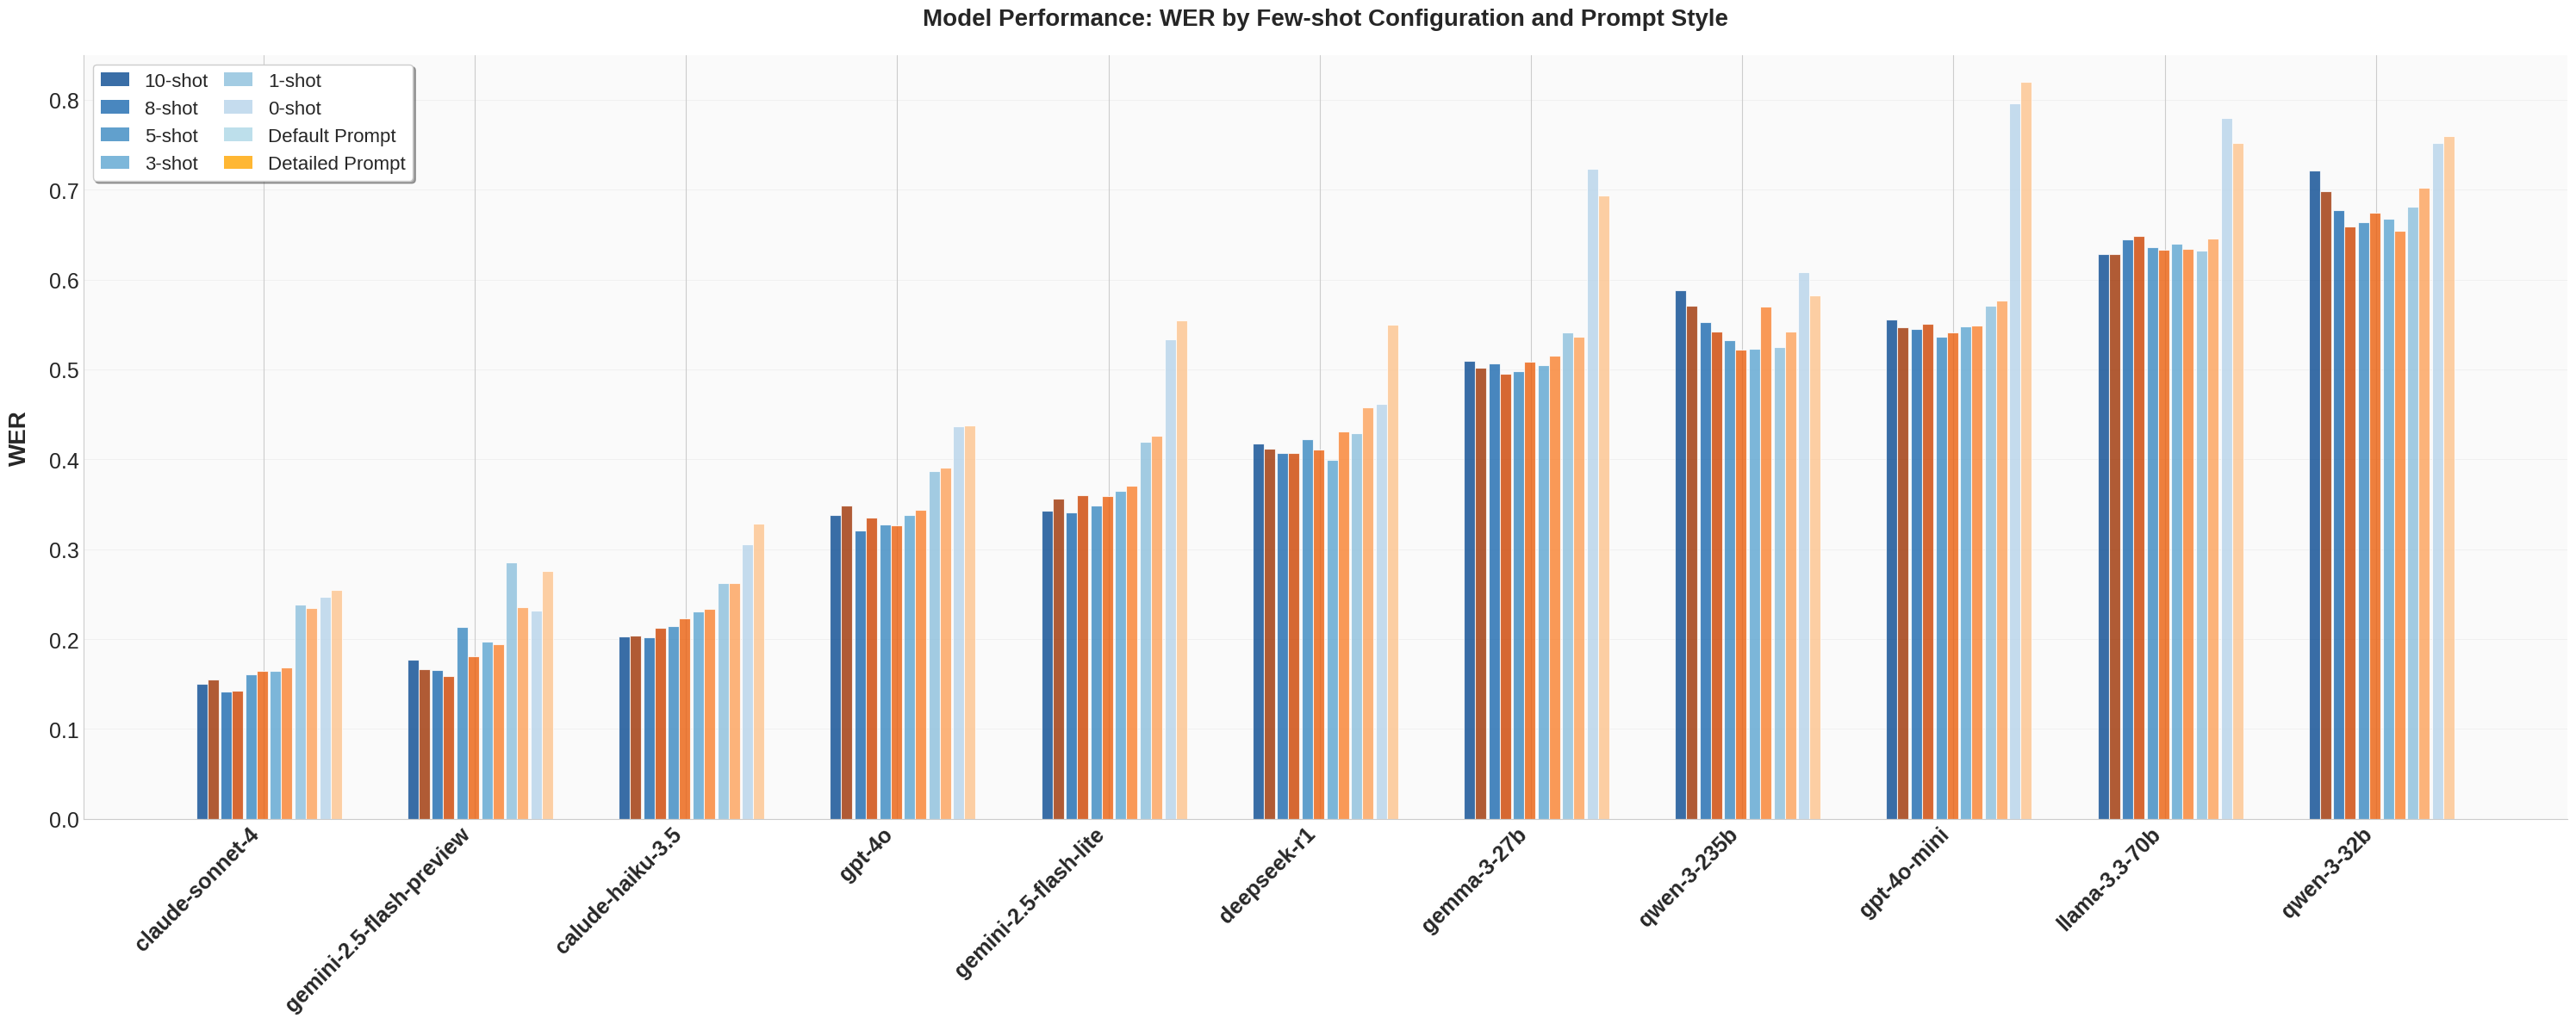

In [5]:
plot_grouped_bars(max_y=0.85)